In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
#!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif  
import nilearn as nl
import nibabel as nib
#from nilearn import plotting as nlpt
#import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [3]:
TRAIN_DATASET_PATH = 'D:/Pavan/FYP/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'D:/Pavan/FYP/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

In [4]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

IMG_SIZE=128


In [5]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)


    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    a1 = Conv2D(32, (15,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    a2 = Conv2D(32, (13,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    a3 = Conv2D(32, (11,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    a4 = Conv2D(32, (9,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    b1 = Conv2D(32, (1,15), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a1)
    b2 = Conv2D(32, (1,13), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a2)
    b3 = Conv2D(32, (1,11), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a3)
    b4 = Conv2D(32, (1,9), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a4)
    b5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    s = b1+b2+b3+b4+b5
    d = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(s)
    e = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(d)
    f = Conv2D(32, 1, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(e)
    
    merge7 = concatenate([f,up7])    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    a1 = Conv2D(32, (15,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    a2 = Conv2D(32, (13,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    a3 = Conv2D(32, (11,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    a4 = Conv2D(32, (9,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    b1 = Conv2D(32, (1,15), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a1)
    b2 = Conv2D(32, (1,13), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a2)
    b3 = Conv2D(32, (1,11), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a3)
    b4 = Conv2D(32, (1,9), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a4)
    b5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    s = b1+b2+b3+b4+b5
    d = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(s)
    e = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(d)
    f = Conv2D(32, 1, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(e)

    merge8 = concatenate([f,up8], axis = 3)    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    a1 = Conv2D(32, (15,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    a2 = Conv2D(32, (13,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    a3 = Conv2D(32, (11,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    a4 = Conv2D(32, (9,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    b1 = Conv2D(32, (1,15), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a1)
    b2 = Conv2D(32, (1,13), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a2)
    b3 = Conv2D(32, (1,11), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a3)
    b4 = Conv2D(32, (1,9), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a4)
    b5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    s = b1+b2+b3+b4+b5   
    d = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(s)
    e = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(d)
    f = Conv2D(32, 1, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(e)
    
    merge9 = concatenate([f,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    a1 = Conv2D(32, (15,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    a2 = Conv2D(32, (13,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    a3 = Conv2D(32, (11,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    a4 = Conv2D(32, (9,1), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    b1 = Conv2D(32, (1,15), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a1)
    b2 = Conv2D(32, (1,13), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a2)
    b3 = Conv2D(32, (1,11), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a3)
    b4 = Conv2D(32, (1,9), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(a4)
    b5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    s = b1+b2+b3+b4+b5
    d = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(s)
    e = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(d)
    f = Conv2D(32, 1, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(e)

    merge = concatenate([f,up], axis = 3)    
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [6]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


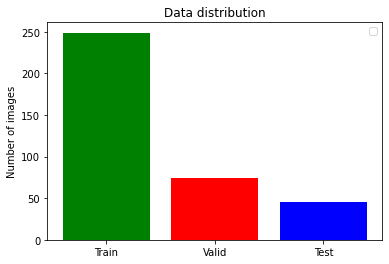

In [9]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [10]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
     keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),
     csv_logger
    ]

In [11]:
K.clear_session()

history =  model.fit(training_generator,
                     epochs=30,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator                     )  
model.save('D:/Pavan/FYP/model_3.h5')

Epoch 1/30
249/249 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9789 - mean_io_u: 0.7058 - dice_coef: 0.2689 - precision: 0.9786 - sensitivity: 0.9705 - specificity: 0.9941 - dice_coef_necrotic: 0.0629 - dice_coef_edema: 0.1222 - dice_coef_enhancing: 0.0512 
Epoch 1: val_loss improved from inf to 0.06560, saving model to model_.01-0.065597.m5
249/249 [==============================] - 7975s 32s/step - loss: 0.2171 - accuracy: 0.9789 - mean_io_u: 0.7058 - dice_coef: 0.2689 - precision: 0.9786 - sensitivity: 0.9705 - specificity: 0.9941 - dice_coef_necrotic: 0.0629 - dice_coef_edema: 0.1222 - dice_coef_enhancing: 0.0512 - val_loss: 0.0656 - val_accuracy: 0.9835 - val_mean_io_u: 0.7443 - val_dice_coef: 0.2806 - val_precision: 0.9833 - val_sensitivity: 0.9833 - val_specificity: 0.9944 - val_dice_coef_necrotic: 0.0902 - val_dice_coef_edema: 0.1622 - val_dice_coef_enhancing: 0.0854 - lr: 0.0010
Epoch 2/30
249/249 [==============================] - ETA: 0s - loss: 0

Epoch 10/30
249/249 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9889 - mean_io_u: 0.7309 - dice_coef: 0.4713 - precision: 0.9917 - sensitivity: 0.9860 - specificity: 0.9971 - dice_coef_necrotic: 0.3406 - dice_coef_edema: 0.5642 - dice_coef_enhancing: 0.5082 
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_loss did not improve from 0.03355
249/249 [==============================] - 8144s 33s/step - loss: 0.0331 - accuracy: 0.9889 - mean_io_u: 0.7309 - dice_coef: 0.4713 - precision: 0.9917 - sensitivity: 0.9860 - specificity: 0.9971 - dice_coef_necrotic: 0.3406 - dice_coef_edema: 0.5642 - dice_coef_enhancing: 0.5082 - val_loss: 0.0354 - val_accuracy: 0.9898 - val_mean_io_u: 0.7669 - val_dice_coef: 0.4719 - val_precision: 0.9920 - val_sensitivity: 0.9871 - val_specificity: 0.9973 - val_dice_coef_necrotic: 0.3255 - val_dice_coef_edema: 0.5212 - val_dice_coef_enhancing: 0.5446 - lr: 0.0010
Epoch 11/30
249/249 [========

Epoch 19/30
249/249 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9930 - mean_io_u: 0.8092 - dice_coef: 0.5952 - precision: 0.9939 - sensitivity: 0.9910 - specificity: 0.9979 - dice_coef_necrotic: 0.5425 - dice_coef_edema: 0.7245 - dice_coef_enhancing: 0.6651 
Epoch 19: val_loss improved from 0.02141 to 0.02120, saving model to model_.19-0.021198.m5
249/249 [==============================] - 7974s 32s/step - loss: 0.0195 - accuracy: 0.9930 - mean_io_u: 0.8092 - dice_coef: 0.5952 - precision: 0.9939 - sensitivity: 0.9910 - specificity: 0.9979 - dice_coef_necrotic: 0.5425 - dice_coef_edema: 0.7245 - dice_coef_enhancing: 0.6651 - val_loss: 0.0212 - val_accuracy: 0.9925 - val_mean_io_u: 0.8102 - val_dice_coef: 0.5784 - val_precision: 0.9934 - val_sensitivity: 0.9907 - val_specificity: 0.9977 - val_dice_coef_necrotic: 0.4584 - val_dice_coef_edema: 0.7165 - val_dice_coef_enhancing: 0.6813 - lr: 4.0000e-05
Epoch 20/30
249/249 [==============================] - ETA: 0

Epoch 28/30
249/249 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9933 - mean_io_u: 0.8152 - dice_coef: 0.6081 - precision: 0.9941 - sensitivity: 0.9915 - specificity: 0.9980 - dice_coef_necrotic: 0.5665 - dice_coef_edema: 0.7383 - dice_coef_enhancing: 0.6711 
Epoch 28: val_loss did not improve from 0.02099
249/249 [==============================] - 5962s 24s/step - loss: 0.0186 - accuracy: 0.9933 - mean_io_u: 0.8152 - dice_coef: 0.6081 - precision: 0.9941 - sensitivity: 0.9915 - specificity: 0.9980 - dice_coef_necrotic: 0.5665 - dice_coef_edema: 0.7383 - dice_coef_enhancing: 0.6711 - val_loss: 0.0210 - val_accuracy: 0.9926 - val_mean_io_u: 0.8128 - val_dice_coef: 0.5850 - val_precision: 0.9935 - val_sensitivity: 0.9909 - val_specificity: 0.9978 - val_dice_coef_necrotic: 0.4775 - val_dice_coef_edema: 0.7142 - val_dice_coef_enhancing: 0.6862 - lr: 1.0000e-06
Epoch 29/30
249/249 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9933 - mean_

In [12]:
############ load trained model ################
model = tf.keras.models.load_model('D:/Pavan/FYP/model_3.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing}, compile=False)

In [13]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        

4/4 [==============================] - 7s 669ms/step


<Figure size 1296x3600 with 0 Axes>

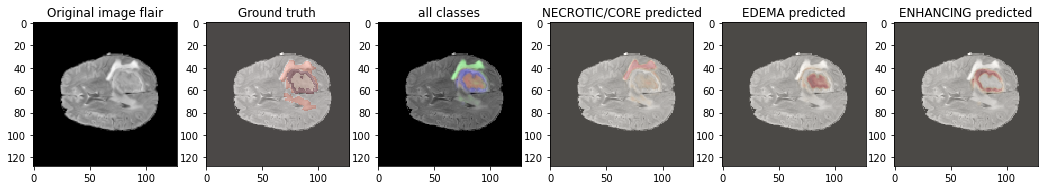

4/4 [==============================] - 3s 656ms/step


<Figure size 1296x3600 with 0 Axes>

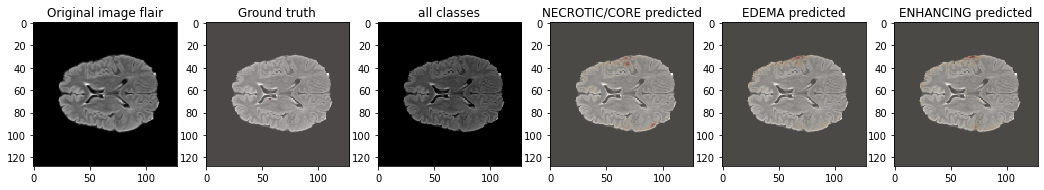

4/4 [==============================] - 3s 666ms/step


<Figure size 1296x3600 with 0 Axes>

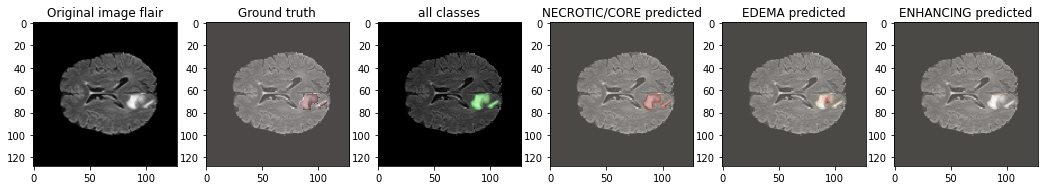

4/4 [==============================] - 3s 672ms/step


<Figure size 1296x3600 with 0 Axes>

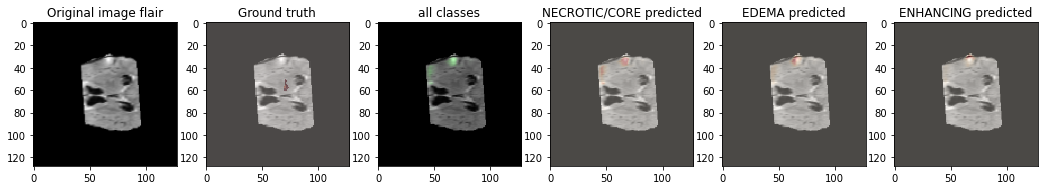

4/4 [==============================] - 3s 662ms/step


<Figure size 1296x3600 with 0 Axes>

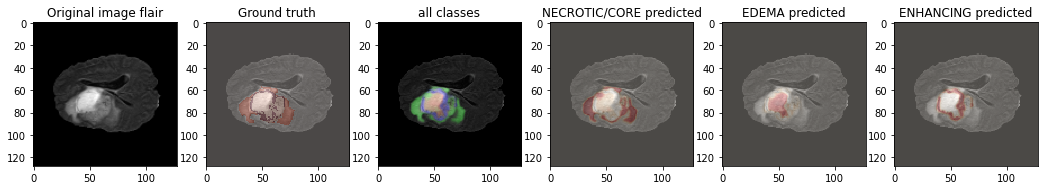

4/4 [==============================] - 3s 667ms/step


<Figure size 1296x3600 with 0 Axes>

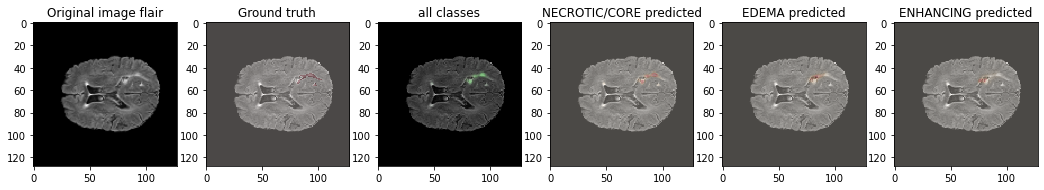

4/4 [==============================] - 3s 677ms/step


<Figure size 1296x3600 with 0 Axes>

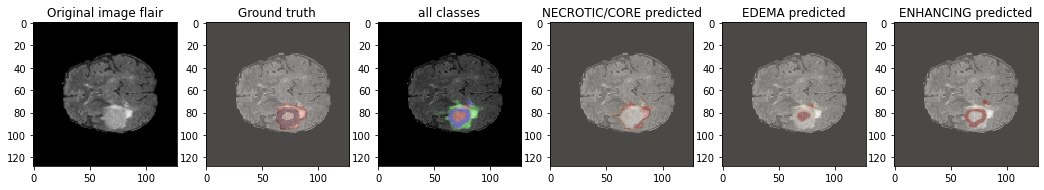

In [14]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"D:/Pavan/FYP/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

In [15]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 153s 3s/step - loss: 0.0240 - accuracy: 0.9927 - mean_io_u_1: 0.8172 - dice_coef: 0.5785 - precision: 0.9935 - sensitivity: 0.9911 - specificity: 0.9978 - dice_coef_necrotic: 0.4931 - dice_coef_edema: 0.6808 - dice_coef_enhancing: 0.6573
test loss, test acc: [0.02398812584578991, 0.992743730545044, 0.8172187805175781, 0.5785236954689026, 0.9935389757156372, 0.9910711646080017, 0.9977994561195374, 0.4930872917175293, 0.6808156967163086, 0.657328188419342]


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  608         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_32 (Conv2D)             (None, 32, 32, 32)   11296       ['conv2d_28[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 32, 32, 32)   36896       ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 32)   9248        ['conv2d_20[0][0]']              
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 512)  0           ['dropout[0][0]']                
                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 32, 32, 32)  0           ['tf.__operators__.add_4[0][0]', 
 mbda)                                                            'conv2d_32[0][0]']              
          

 conv2d_60 (Conv2D)             (None, 128, 128, 32  15392       ['conv2d_56[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 128, 128, 32  13344       ['conv2d_57[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 32  11296       ['conv2d_1[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 64, 64, 32)   9248        ['tf.__operators__.add_11[0][0]']
          